# Parameters

In [1]:
domain = "HIV_nef"
MHCs = ['HLA-A*02:01', 'HLA-A*24:02', 'HLA-B*07:02', 'HLA-B*39:01', 'HLA-C*07:01', 'HLA-C*16:01']  

XVAE_job = "mlp_1606474"  # the CAPE-XVAE model

predictor_structure_name = "AF"  # ESM or AF
predictor_MHC_I_class = 'netMHCpan'  # which presentation predictor to use to assessment of visibility
predictor_MHC_I_limit = 2
predictor_MHC_I_name = f"{predictor_MHC_I_class}_{predictor_MHC_I_limit*100}"
predictor_function_name = None

deimmunize_visibility_percentile = 0.005
immunize_visibility_percentile = 0.995

create_DB = False
update_DB = True
save_figures = True

run_MSA = False
predictor_MHC_I_save = False

# Imports

In [2]:
import os

In [3]:
import importlib
from dotenv import load_dotenv
import os
import sys

load_dotenv()
sys.path = [os.environ['PYTHONPATH']]+ sys.path

In [4]:
import kit
from kit.log import log_info
import kit.globals as G
from kit.path import join
from kit.bioinf import get_kmers
from kit.bioinf.sf import SequenceFrame
from kit.bioinf.mhc import get_predictor
from kit.bioinf.fasta import read_fasta, seqs_to_fasta
from kit.bioinf.alignment.sequence import PairwiseSequenceAligner, MultipleSequenceAligner
from kit.data import DD, set_df_cell_to_np, get_np_from_df_cell, str_to_file

import os
import string
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import pickle
from collections import defaultdict
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.manifold import TSNE, MDS
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.decomposition import PCA
import mdtraj as md

/home/tux/miniconda3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Load .env file


In [5]:
from CAPE.utils import cp_translated_fastas_to_path

In [54]:
from CAPE.Eval import CapeDB
from CAPE.Eval.utils import pack_to_source_task_step
from CAPE.Eval.kmers import add_recall, add_precision, add_precision_to_seq_kmers, calc_recall_metrics
from CAPE.Eval.plot import set_palettes, set_markers, \
    plot_TSNE_kde, plot_avg_dissimilarity_boxplots, plot_boxplots, plot_kmer_similarity, plot_kmer_similarity_box, plot_vs_visibility, \
    plot_seq_epitopes, plot_seq_precision_pie, plot_epitope_recall_by_seq, plot_seqs_precision_bar

In [7]:
# Enable LaTeX text rendering
plt.rcParams['text.usetex'] = True

In [8]:
kit.init("CAPE", "CAPE-Eval", create_job=False)
G.DOMAIN = domain

Startup with args: Namespace(task='', job='AUTO', domain='d', env='py', device='cuda', debug=None) ENV.PROJECT: '/media/thoth/FILES/study/ed/PhD/projects/cape'
2023-10-18 18:29:48:  WARNING: TASK NOT SPECIFIED
2023-10-18 18:29:48:  Start CAPE-None-None on py using cuda
2023-10-18 18:29:48:  G.ENV
2023-10-18 18:29:48:  PROJECT   ... /media/thoth/FILES/study/ed/PhD/projects/cape
2023-10-18 18:29:48:  ID        ... py
2023-10-18 18:29:48:  KIT       ... /media/thoth/FILES/study/ed/PhD/projects/cape/artefacts/kit
2023-10-18 18:29:48:  RAW       ... /media/thoth/FILES/study/ed/PhD/projects/cape/data/raw
2023-10-18 18:29:48:  INPUT     ... /media/thoth/FILES/study/ed/PhD/projects/cape/data/input
2023-10-18 18:29:48:  CONFIG    ... /media/thoth/FILES/study/ed/PhD/projects/cape/configs/CAPE-Eval
2023-10-18 18:29:48:  ARTEFACTS ... /media/thoth/FILES/study/ed/PhD/projects/cape/artefacts/CAPE-Eval
2023-10-18 18:29:48:  ARTEFACTS_SHARED... /media/thoth/FILES/study/ed/PhD/projects/cape/artefacts/C

# Constants

In [9]:
model_checkpoint = f"{XVAE_job}:last"
DHPARAMS_path = os.path.join(G.ENV.PROJECT, 'artefacts', 'CAPE-XVAE', 'jobs', XVAE_job, 'DHPARAMS.yaml')
DHPARAMS = DD.from_yaml(DHPARAMS_path)

In [10]:
directions = ['deimmunize', 'immunize']

limit_PWM = 2
limit_eval = 2
limits = [0.5, 2]  # used for table generation with predictor_eval


modparams_ = ['modparams']

# TSNE
TSNE_perplexity = 30
TSNE_iter = 500
tsne_rep_name = f"tsne_{TSNE_perplexity}_{TSNE_iter}"

# MDS
mds_rep_name = "MDS"

# PCA
pca_rep_name = f"pca"

In [11]:
source_xvae = 'CAPE-XVAE'
source_packer = 'CAPE-Packer'

programs = [source_xvae, source_packer]
profiles = ['baseline', 'deimmunize', 'immunize']
steps = ['final', 'clean']

In [12]:
kmer_similarity_lengths = list(range(3,16))

In [13]:
open_gap_score = -20
extend_gap_score = -10

pairwise_sequence_aligner = PairwiseSequenceAligner(
    substitution_matrix="BLOSUM62", 
    open_gap_score=open_gap_score, 
    extend_gap_score=extend_gap_score, 
    wildcard="-"
)

In [14]:
A4_width = 8.27
A4_height = 11.69

# DB

In [15]:
db = CapeDB(join(G.ENV.ARTEFACTS, "DBs", "CAPE-Eval.db"), 
            G.DOMAIN, os.environ['LOCH'], 
            None, 
            predictor_structure_name,
            predictor_function_name,
            pairwise_sequence_aligner,
            create_database=create_DB
           )

In [16]:
## Create packs

if update_DB:
    db.cursor.execute('''DELETE FROM packs''')
    db.conn.commit()
    
    # Data
    db.add_seq_hashes_as_pack(os.path.join(G.ENV.PROJECT, 'artefacts', 'CAPE', f'{G.DOMAIN}.data.TRAIN.seq_hash'))
    db.add_seq_hashes_as_pack(os.path.join(G.ENV.PROJECT, 'artefacts', 'CAPE', f'{G.DOMAIN}.data.VAL.seq_hash'))
    db.add_seq_hashes_as_pack(os.path.join(G.ENV.PROJECT, 'artefacts', 'CAPE', f'{G.DOMAIN}.data.TEST.seq_hash'))
    
    # Supports
    db.add_seq_hashes_as_pack(os.path.join(G.ENV.PROJECT, 'artefacts', 'CAPE', f'{G.DOMAIN}.support.seq_hash'))
  
    # CAPE-XVAE
    db.add_seq_hashes_as_pack(os.path.join(G.ENV.PROJECT, 'artefacts', 'CAPE-XVAE', f'{G.DOMAIN}.CAPE-XVAE.baseline.clean.seq_hash'))
    db.add_seq_hashes_as_pack(os.path.join(G.ENV.PROJECT, 'artefacts', 'CAPE-XVAE', f'{G.DOMAIN}.CAPE-XVAE.deimmunize.final.seq_hash'))
    db.add_seq_hashes_as_pack(os.path.join(G.ENV.PROJECT, 'artefacts', 'CAPE-XVAE', f'{G.DOMAIN}.CAPE-XVAE.immunize.final.seq_hash'))
    
    # CAPE-Packer
    db.add_seq_hashes_as_pack(os.path.join(G.ENV.PROJECT, 'artefacts', 'CAPE-Packer', f'{G.DOMAIN}.CAPE-Packer.baseline.final.seq_hash'))
    db.add_seq_hashes_as_pack(os.path.join(G.ENV.PROJECT, 'artefacts', 'CAPE-Packer', f'{G.DOMAIN}.CAPE-Packer.deimmunize.final.seq_hash'))
    db.add_seq_hashes_as_pack(os.path.join(G.ENV.PROJECT, 'artefacts', 'CAPE-Packer', f'{G.DOMAIN}.CAPE-Packer.immunize.final.seq_hash'))
    
    db.conn.commit()

data.TRAIN


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24026/24026 [00:15<00:00, 1538.95it/s]


data.VAL


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1334/1334 [00:00<00:00, 1576.20it/s]


data.TEST


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1336/1336 [00:00<00:00, 1665.69it/s]


support


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:00<00:00, 2017.81it/s]


CAPE-XVAE.baseline.clean


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1523.89it/s]


CAPE-XVAE.deimmunize.final


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1510.00it/s]


CAPE-XVAE.immunize.final


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1569.17it/s]


CAPE-Packer.baseline.final


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:00<00:00, 1568.21it/s]


CAPE-Packer.deimmunize.final


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:00<00:00, 1543.56it/s]


CAPE-Packer.immunize.final


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:00<00:00, 1440.86it/s]


# Evaluation

In [17]:
sql = f'''
    SELECT p.pack, p.seq_hash, s.seq
    FROM packs p LEFT JOIN sequences s ON p.seq_hash == s.seq_hash
    WHERE p.domain == '{G.DOMAIN}' AND s.complete == 1
'''
df_eval = db.sql_to_df(sql)
print(f"{len(df_eval)} evaluation entries")

25256 evaluation entries


In [18]:
df_eval['source'], df_eval['task'], df_eval['step'] = None, None, None
for idx, row in df_eval.iterrows():
    source, task, step = pack_to_source_task_step(row.pack)

    df_eval.at[idx, 'source'] = source
    df_eval.at[idx, 'task'] = task
    df_eval.at[idx, 'step'] = step

N_Supports = len(df_eval.query("source == 'support'"))
print(N_Supports)

300


In [19]:
df_eval['seq_length'] = df_eval.apply(lambda row: len(row.seq), axis=1)
df_eval[['pack', 'seq_length']].groupby(['pack']).aggregate(['min', 'mean', 'max'])

seq_length                 
                                    min        mean  max
pack                                                    
CAPE-Packer.baseline.final          200  207.556667  218
CAPE-Packer.deimmunize.final        200  207.556667  218
CAPE-Packer.immunize.final          200  207.556667  218
CAPE-XVAE.baseline.clean            201  206.960000  217
CAPE-XVAE.deimmunize.final          206  215.680000  218
CAPE-XVAE.immunize.final            208  216.190000  218
data.TEST                           200  207.665265  218
data.TRAIN                          200  207.740294  218
data.VAL                            200  207.899075  218
support                             200  207.556667  218

## Immune Visibility

### Load Predictors

In [20]:
predictor_MHC_I = get_predictor(predictor_MHC_I_class)(
    join(G.ENV.PROJECT, 'artefacts', 'immunology', 'netMHCpan', 'percentile'), 
    limit=predictor_MHC_I_limit/100,
    MHC_I_alleles_to_load=MHCs
)

2023-10-18 18:30:09:  Init <class 'kit.bioinf.mhc.netMHCpan.netMHCpanPredictor'> MHC-Class1 predictor
2023-10-18 18:30:09:  Loading HLA-B*07:02 from percentile_HLA_B_07_02.tsv
2023-10-18 18:30:11:  Loading HLA-C*07:01 from percentile_HLA_C_07_01.tsv
2023-10-18 18:30:14:  Loading HLA-C*16:01 from percentile_HLA_C_16_01.tsv
2023-10-18 18:30:15:  Loading HLA-A*24:02 from percentile_HLA_A_24_02.tsv
2023-10-18 18:30:18:  Loading HLA-B*39:01 from percentile_HLA_B_39_01.tsv
2023-10-18 18:30:20:  Loading HLA-A*02:01 from percentile_HLA_A_02_01.tsv


### Predict Visibility

In [21]:
db.predictors_MHC_I = {predictor_MHC_I_name: predictor_MHC_I}

In [22]:
for mhc in tqdm(MHCs, desc="MHCs"):
    db.add_visibility_MHC_I(predictor_MHC_I_name, mhc)
    db.conn.commit()

MHCs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 70.68it/s]


In [23]:
if predictor_MHC_I_save:
    predictor_MHC_I.save()

In [24]:
df_eval['visibility'] = None
for idx, row in tqdm(df_eval.iterrows()):
    df_eval.at[idx, 'visibility'] = db.get_visibility_MHC_I(predictor_MHC_I_name, MHCs, row.seq_hash)
df_eval['visibility'] = df_eval['visibility'].astype('float')

25256it [00:02, 9109.72it/s]


In [25]:
df_natural = df_eval.query('source == "natural"')
deimmunize_visibility_threshold = np.percentile(df_natural.visibility, deimmunize_visibility_percentile*100)
immunize_visibility_threshold = np.percentile(df_natural.visibility, immunize_visibility_percentile*100)
print(f"deimmunize_visibility_threshold: {deimmunize_visibility_threshold}")
print(f"immunize_visibility_threshold: {immunize_visibility_threshold}")

deimmunize_visibility_threshold: 72.0
immunize_visibility_threshold: 107.0


In [26]:
df_eval[['pack', 'visibility']].groupby('pack').agg(['min', 'mean', 'max'])

visibility                   
                                    min        mean    max
pack                                                      
CAPE-Packer.baseline.final         40.0   71.166667  115.0
CAPE-Packer.deimmunize.final       19.0   41.306667   68.0
CAPE-Packer.immunize.final        219.0  285.966667  360.0
CAPE-XVAE.baseline.clean           63.0   86.100000  119.0
CAPE-XVAE.deimmunize.final         18.0   52.180000   97.0
CAPE-XVAE.immunize.final           91.0  146.420000  234.0
data.TEST                          70.0   86.967199  108.0
data.TRAIN                         64.0   86.813687  129.0
data.VAL                           65.0   86.921783  117.0
support                            73.0   86.706667  111.0

## Similarity

### Structure

In [27]:
df_eval['max_TMscore_support_seq_hash'], df_eval['max_TMscore'], df_eval['max_TMscore_aligned_length'] = "", None, None

In [28]:
packs = [
    ('support', False),
       
    ('CAPE-XVAE.baseline.clean', True),
    ('CAPE-XVAE.deimmunize.final', True),
    ('CAPE-XVAE.immunize.final', True),
    
    ('CAPE-Packer.baseline.final', True),
    ('CAPE-Packer.deimmunize.final', True),
    ('CAPE-Packer.immunize.final', True),
]

In [29]:
if df_eval.index.name is not None:
    df_eval.reset_index(inplace=True)
df_eval.set_index('seq_hash', inplace=True)
for pack, self_match in packs:
    df = db.get_pack(pack)
    cnt = 0
    for _, row in tqdm(df.iterrows()):
        seq_hash = row['seq_hash']
        if os.path.exists(db.get_pdb_file_path(seq_hash)):
            sequence = db.get_sequence(seq_hash=seq_hash)
            max_TMscore_support_seq_hash, max_TMscore, max_TMscore_aligned_length = db.get_closest(sequence['seq'], self_match=self_match)
    
            df_eval.at[seq_hash, 'max_TMscore_support_seq_hash'] = max_TMscore_support_seq_hash
            df_eval.at[seq_hash, 'max_TMscore'] = max_TMscore
            df_eval.at[seq_hash, 'max_TMscore_aligned_length'] = max_TMscore_aligned_length
            cnt += 1
    print(f"{pack}: {cnt} aligned")
df_eval.reset_index(inplace=True)
df_eval.max_TMscore = df_eval.max_TMscore.astype('float')

print(f'len(df_eval): {len(df_eval)}')

300it [00:42,  7.10it/s]


support: 300 aligned


100it [00:14,  7.12it/s]


CAPE-XVAE.baseline.clean: 100 aligned


100it [00:14,  7.09it/s]


CAPE-XVAE.deimmunize.final: 100 aligned


100it [00:14,  7.11it/s]


CAPE-XVAE.immunize.final: 100 aligned


300it [00:42,  7.12it/s]


CAPE-Packer.baseline.final: 300 aligned


300it [00:42,  7.13it/s]


CAPE-Packer.deimmunize.final: 300 aligned


300it [00:42,  7.11it/s]

CAPE-Packer.immunize.final: 300 aligned
len(df_eval): 25256


In [30]:
print(f"{'pack':40s} | {'mean':5} | {'std':5} | {'min':5} | {'max':5}")

for pack, _ in packs:
    mean = df_eval.query(f'pack == "{pack}"')['max_TMscore'].mean()
    std = df_eval.query(f'pack == "{pack}"')['max_TMscore'].std()
    min = df_eval.query(f'pack == "{pack}"')['max_TMscore'].min()
    max = df_eval.query(f'pack == "{pack}"')['max_TMscore'].max()
    print(f"{pack:40s} | {mean:5.3f} | {std:5.3f} | {min:5.3f} | {max:5.3f}")

pack                                     | mean  | std   | min   | max  
support                                  | 0.966 | 0.024 | 0.873 | 0.997
CAPE-XVAE.baseline.clean                 | 0.838 | 0.133 | 0.405 | 0.996
CAPE-XVAE.deimmunize.final               | 0.756 | 0.174 | 0.210 | 0.976
CAPE-XVAE.immunize.final                 | 0.792 | 0.154 | 0.250 | 0.983
CAPE-Packer.baseline.final               | 0.800 | 0.057 | 0.572 | 0.933
CAPE-Packer.deimmunize.final             | 0.794 | 0.065 | 0.563 | 0.938
CAPE-Packer.immunize.final               | 0.763 | 0.067 | 0.588 | 0.894


In [31]:
print(f"{'pack':40s} | {'mean':5} | {'std':5} | {'min':5} | {'max':5}")

for pack, _ in packs:
    mean = df_eval.query(f'pack == "{pack}"')['max_TMscore_aligned_length'].mean()
    std = df_eval.query(f'pack == "{pack}"')['max_TMscore_aligned_length'].std()
    min = df_eval.query(f'pack == "{pack}"')['max_TMscore_aligned_length'].min()
    max = df_eval.query(f'pack == "{pack}"')['max_TMscore_aligned_length'].max()
    print(f"{pack:40s} | {mean:5.1f} | {std:5.1f} | {min:5.1f} | {max:5.1f}")

pack                                     | mean  | std   | min   | max  
support                                  | 205.2 |   4.1 | 184.0 | 217.0
CAPE-XVAE.baseline.clean                 | 189.0 |  18.5 | 126.0 | 209.0
CAPE-XVAE.deimmunize.final               | 179.7 |  28.3 |  64.0 | 210.0
CAPE-XVAE.immunize.final                 | 184.9 |  23.3 |  83.0 | 215.0
CAPE-Packer.baseline.final               | 187.3 |  11.4 | 148.0 | 212.0
CAPE-Packer.deimmunize.final             | 185.8 |  13.2 | 140.0 | 210.0
CAPE-Packer.immunize.final               | 180.9 |  15.5 | 137.0 | 208.0


### Sequence

#### K-mers

In [32]:
natural_kmers_data_file_path = os.path.join(G.ENV.ARTEFACTS, f"{G.DOMAIN}.kmers.natural.pickle")
if os.path.exists(natural_kmers_data_file_path):
    with open(natural_kmers_data_file_path, "rb") as file:
        natural_kmers_data = pickle.load(file)
else:
    natural_kmers_dict = {length: {} for length in kmer_similarity_lengths}
    df_natural = df_eval.query('source == "natural"')
    for idx, row in tqdm(df_natural.iterrows()):
        for length in kmer_similarity_lengths:
            kmers = get_kmers(row.seq, lengths=[length])
            for kmer in kmers:
                natural_kmers_dict[length][kmer] = natural_kmers_dict[length].get(kmer, 0) + 1

    natural_kmers_data = {
        'natural_kmers_dict': natural_kmers_dict,
        'n_natural': len(df_natural)
    }
    with open(natural_kmers_data_file_path, "wb") as file:
        pickle.dump(natural_kmers_data, file)

natural_kmers_dict = natural_kmers_data['natural_kmers_dict']

natural_kmers = set()
natural_kmers.update(*[set(natural_kmers_dict[length].keys()) for length in kmer_similarity_lengths])
print(f"K-mer count: {len(natural_kmers):,}")

K-mer count: 2,914,221


In [33]:
df_eval[f'kmer_similarity'] = None
for k in kmer_similarity_lengths:
    df_eval[f'{k}mer_similarity'] = None


a_len = np.max(kmer_similarity_lengths) + 1
for idx, row in tqdm(df_eval.iterrows()):
    natural_kmers_cnt, artificial_kmers_cnt = [0]*a_len, [0]*a_len

    kmers = get_kmers(row.seq, lengths=kmer_similarity_lengths)
    for kmer in kmers:
        length = len(kmer)
        if kmer in natural_kmers:
            natural_kmers_cnt[length] += 1
        else:
            artificial_kmers_cnt[length] += 1
                
    df_eval.at[idx, 'kmer_similarity'] = np.sum(natural_kmers_cnt) / (np.sum(natural_kmers_cnt) + np.sum(artificial_kmers_cnt))
    for k in kmer_similarity_lengths:
        df_eval.at[idx, f'{k}mer_similarity'] = natural_kmers_cnt[k] / (natural_kmers_cnt[k] + artificial_kmers_cnt[k])
    
df_eval.kmer_similarity = df_eval.kmer_similarity.astype('float')
for k in kmer_similarity_lengths:
    df_eval[f'{k}mer_similarity'] = df_eval[f'{k}mer_similarity'].astype('float')

25256it [01:09, 365.64it/s]


## Stability

### MD simulations

In [41]:
md_param_hash = '675742'
df_eval['md_rmsd'], df_eval['md_max_rmsd'], df_eval['md_rmsf'] = None, None, None

In [42]:
if df_eval.index.name is not None:
    df_eval.reset_index(inplace=True)
df_eval.set_index('seq_hash', inplace=True)

for seq_hash, row in df_eval.iterrows():
    md_path = db.get_md_path(seq_hash, md_param_hash)
    dcd_file_path = os.path.join(md_path, 'output_sub.dcd')
    if os.path.exists(dcd_file_path):
        print(seq_hash)

        pdb_file_path = db.get_pdb_file_path(seq_hash)
        structure = md.load(pdb_file_path)
        topology = md.load_topology(pdb_file_path)
        alpha_carbon_atoms = [atom.index for atom in topology.atoms if atom.name == 'CA']

        # reduce the topology to its CA atoms
        topology_sub = md.Topology()
        chain = topology_sub.add_chain()
        for r, _ in enumerate(alpha_carbon_atoms):
            res = topology_sub.add_residue(topology.residue(r), chain)
            topology_sub.add_atom(f"CA{r}", "C", res)
        
        trajectory = md.load_dcd(dcd_file_path, top=topology_sub)

        rmsd = md.rmsd(trajectory, trajectory[0])
        rmsf = md.rmsf(trajectory, trajectory[0])

        df_eval.at[seq_hash, 'md_max_rmsd'] = rmsd.max()
        set_df_cell_to_np(df_eval, seq_hash, 'md_rmsd', rmsd)
        set_df_cell_to_np(df_eval, seq_hash, 'md_rmsf', rmsf)

# np.frombuffer(rmsd.astype(np.dtype('float32')).tobytes(), dtype=np.dtype('float32'))

df_eval.md_max_rmsd = df_eval.md_max_rmsd.astype('float')

df_eval.reset_index(inplace=True)

0008f261b784ee03873e4b10aa52915f5fd88b390d9f12dc40aff8f9fd8be985
004025ebbe75f0da615d5336e352522be239fa11fadbc3487a21f8710465d668
004f0f3b968a6dcdee60a3d6ed6ee61e33cd20d7a6b1e5bd2a6dbdf6965a3702
005dbad3fdb3e6a4a9c80bfaa5f789f555921eb400678fc42a44ad6f17f28423
0150d515ae8849b17d90b3738e5fd9e18a8a191c0919dbdeec9c1b3e13a38700
016f30123f6b9ec15d3689eb75943fcd852d42b3a55c61a713ff360a03dc4fac
01985c8adac151ea7bfbafb06ed721fafcce6a0d77f8ce1fa73b9f6685e137a2
01fc917dd94dbd4875050c65fa81dcb35ad63a4424e4cd61720559eea26d083d
020644853f09cb29ebd229f85c7366c69cbfa6672c208fed1b6c77440753f6c0
021c25363ab10097040c87dee145ede771e15f1879ce9acde87f40d7fa29d784
02480a8f7c7104d90e24e8c4d6b5782bef86714ad69cf9b2f24099dd238eee32
02480a8f7c7104d90e24e8c4d6b5782bef86714ad69cf9b2f24099dd238eee32
02943c41f6f418c2a224cd1a5f00c31b1dc62222a702d9ac749e2a31002c64a4
02943c41f6f418c2a224cd1a5f00c31b1dc62222a702d9ac749e2a31002c64a4
03835e3950ceb595a6ba9a99d2591e3066f8df5917ea1f6f22b475093fedfce2
03835e3950ceb595a6ba9a99d

In [43]:
df_eval.query("not md_rmsd.isnull()")[['seq_hash', 'pack']].groupby('pack').count()

,seq_hash
pack,
CAPE-Packer.baseline.final,10
CAPE-Packer.deimmunize.final,29
CAPE-Packer.immunize.final,21
CAPE-XVAE.baseline.clean,10
CAPE-XVAE.deimmunize.final,25
CAPE-XVAE.immunize.final,25
data.TRAIN,10
support,10


# Visualizations

## represent

### support representation

In [44]:
db.add_support_rep()

missing representations: 0it [00:00, ?it/s]


### tSNE support representation

In [45]:
tsne = TSNE(n_components=2, verbose=0, perplexity=TSNE_perplexity, n_iter=TSNE_iter)
tsne_rep_base_hash = db.add_reduced_support_rep(df_eval, tsne_rep_name, tsne)
df_TSNE = db.get_rep(tsne_rep_name, tsne_rep_base_hash).rename(columns={'rep_1': 't-SNE 1', 'rep_2': 't-SNE 2'})
df_eval = df_eval[[c for c in df_eval.columns if c not in ['t-SNE 1', 't-SNE 2']]].join(df_TSNE, how='left', on='seq_hash')

### MDS support representation

In [46]:
#mds = MDS()
#mds_rep_base_hash = db.add_reduced_support_rep(df_eval, mds_rep_name, mds)
#df_MDS = db.get_rep(mds_rep_name, mds_rep_base_hash).rename(columns={'rep_1': 'MDS 1', 'rep_2': 'MDS 2'})
#df_eval = df_eval[[c for c in df_eval.columns if c not in ['MDS 1', 'MDS 2']]].join(df_MDS, how='left', on='seq_hash')

### PCA support representation

In [47]:
pca = PCA(n_components=2)
pca_rep_base_hash = db.add_reduced_support_rep(df_eval, pca_rep_name, pca)
df_PCA = db.get_rep(pca_rep_name, pca_rep_base_hash).rename(columns={'rep_1': 'PCA 1', 'rep_2': 'PCA 2'})
df_eval = df_eval[[c for c in df_eval.columns if c not in ['PCA 1', 'PCA 2']]].join(df_PCA, how='left', on='seq_hash')

### Dissimilarities

In [73]:
if df_eval.index.name is not None:
    df_eval.reset_index(inplace=True)
df_eval.set_index('seq_hash', inplace=True)


dissimilarity_src_packs = [
    # (source, [packs])
    ('support', ['support']), 
    (source_xvae, [
        f"{source_xvae}.baseline.clean", 
        f"{source_xvae}.deimmunize.final", 
        f"{source_xvae}.immunize.final"
    ]), 
    (source_packer, [
        f"{source_packer}.baseline.final",
        f"{source_packer}.deimmunize.final",
        f"{source_packer}.immunize.final"
    ])
]

dissimilarity_tgt_packs = [
    f'support',
    f'{source_packer}.baseline.final'
]

for pack_name in dissimilarity_tgt_packs:
    column = f'avg_dissimilarity_{pack_name}'
    df_eval[column] = None

for src_pack in tqdm(dissimilarity_src_packs):
    for pack_1_name in src_pack[1]:
        df_pack_1 = db.get_pack(pack_1_name)
        for pack_2_name in dissimilarity_tgt_packs:
            column = f'avg_dissimilarity_{pack_2_name}'
            df_pack_2 = db.get_pack(pack_2_name)
            for _, row in df_pack_1.iterrows():
                value = np.mean(pairwise_sequence_aligner.get_seq_to_seqs_dissimilarity(row.seq, df_pack_2.seq))
                df_eval.at[row.seq_hash, column] = value

df_eval.reset_index(inplace=True)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:36<00:00, 32.14s/it]


## Plot

In [49]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

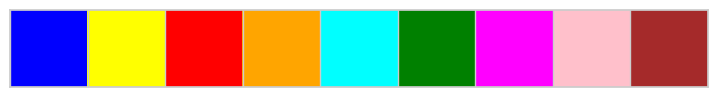

In [106]:
color_palette = ['blue', 'yellow', 'red', 'orange', 'cyan', 'green', 'magenta', 'pink', 'brown']
#color_palette = sns.color_palette('colorblind')
sns.palplot(color_palette)

In [107]:
palettes = {
    'pack': {# Pack-name: Color
        'support': color_palette[0],
        'data.TRAIN': color_palette[0],
        'data.VAL': color_palette[0],
        'data.TEST': color_palette[0],

        f'{source_xvae}.baseline.clean': color_palette[1],
        f'{source_xvae}.deimmunize.final': color_palette[2],     
        f'{source_xvae}.immunize.final': color_palette[3], 

        f'{source_packer}.baseline.final': color_palette[4],
        f'{source_packer}.deimmunize.final': color_palette[5], 
        f'{source_packer}.immunize.final': color_palette[6]
    },
    'source': {
        'support': color_palette[0],
        'natural': color_palette[0],
        source_xvae: color_palette[7],
        source_packer: color_palette[8]
    }    
}
set_palettes(palettes)

In [108]:
styles = {'natural': 'o', 'CAPE-XVAE': 'o', 'CAPE-Packer': 'o'}
markers = {
    'pack': {      
        'support': styles['natural'],
        'data.TRAIN': styles['natural'],
        'data.VAL': styles['natural'],
        'data.TEST': styles['natural'],

        f'{source_xvae}.baseline.clean': styles['CAPE-XVAE'],
        f'{source_xvae}.deimmunize.final': styles['CAPE-XVAE'],    
        f'{source_xvae}.immunize.final': styles['CAPE-XVAE'],

        f'{source_packer}.baseline.final': styles['CAPE-Packer'],
        f'{source_packer}.deimmunize.final': styles['CAPE-Packer'],
        f'{source_packer}.immunize.final': styles['CAPE-Packer'],        
    },
    'source': {
        'support': palettes['pack']['support'],
        'natural': palettes['pack']['data.TRAIN'],
        source_xvae: styles['CAPE-XVAE'],
        source_packer: styles['CAPE-Packer'],
    }    
}
set_markers(markers)

### Figure A - Low-dimensional sequence space representation

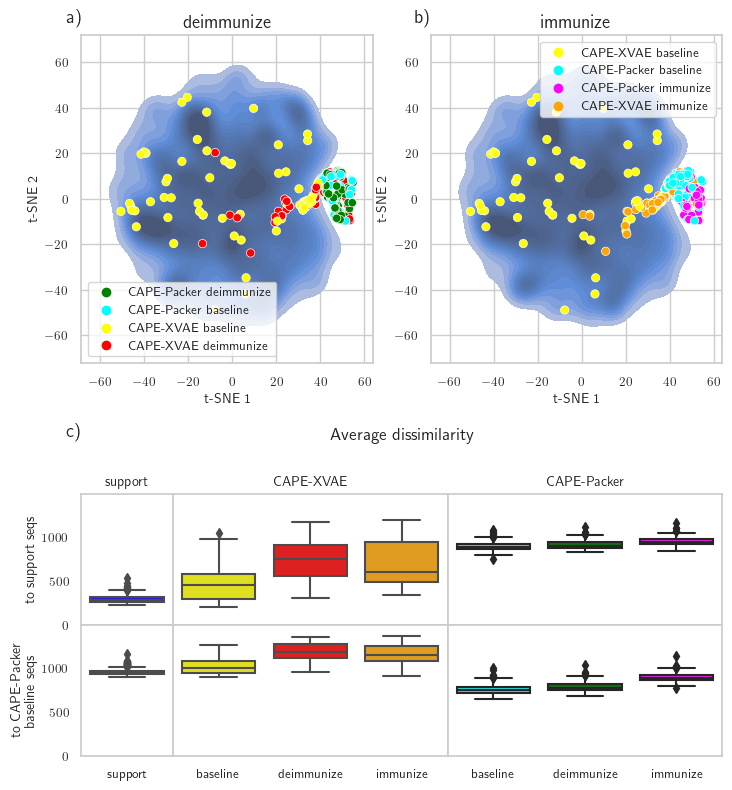

In [89]:
font_scale=10/12
fig = plt.figure(figsize=(A4_width, A4_height*4/5))
all_axes = []
gs = mpl.gridspec.GridSpec(2, 2, 
                           width_ratios=[1, 1], 
                           height_ratios=[2, 2], 
                           wspace=0.2, hspace=0.2)

for direction, position in zip(['deimmunize', 'immunize'], [0, 1]):
    dots_packs = [f'CAPE-XVAE.baseline.clean', 
                  f'CAPE-XVAE.{direction}.final', 
                  f'CAPE-Packer.baseline.final',
                  f'CAPE-Packer.{direction}.final']
    all_axes.append(plot_TSNE_kde(direction, df_eval, 'data', dots_packs, gs[0, position], font_scale=font_scale))
    
all_axes.append(plot_avg_dissimilarity_boxplots('Average dissimilarity', df_eval, 
                    dissimilarity_src_packs, dissimilarity_tgt_packs, 
                    1500, gs[1,:], font_scale=font_scale))

labels = [f'{c})' for c in string.ascii_lowercase]
for i, ax in enumerate(all_axes):
    ax.text(-0., 1.08, labels[i], transform=ax.transAxes,
            fontsize=16*font_scale, fontweight='bold', va='top', ha='right') #, color='red')

if save_figures:
    fig.savefig(kit.path.join(G.ENV.ARTEFACTS, "figures", G.DOMAIN, f"Figure_A.pdf"), bbox_inches='tight')

### Figure B - Visibility and Similarity

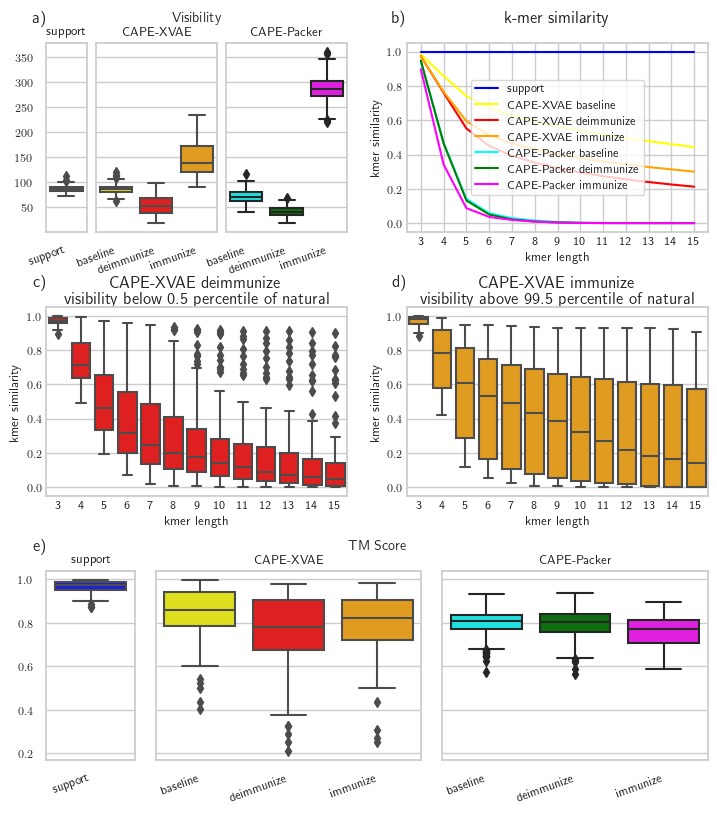

In [57]:
font_scale=9/12
fig = plt.figure(figsize=(A4_width, A4_height*0.8))
all_axes = []
gs = mpl.gridspec.GridSpec(3, 2, 
                           width_ratios=[1, 1], 
                           height_ratios=[1, 1, 1], 
                           wspace=0.2, hspace=0.2)



all_axes.append(plot_boxplots("Visibility", 
                              df_eval, 
                              "visibility", 
                              ["support", source_xvae, source_packer], gs[0, 0], font_scale))
all_axes.append(plot_kmer_similarity(df_eval, [
    "support", 
    "CAPE-XVAE.baseline.clean", "CAPE-XVAE.deimmunize.final", "CAPE-XVAE.immunize.final",
    "CAPE-Packer.baseline.final", "CAPE-Packer.deimmunize.final", "CAPE-Packer.immunize.final"
    ], kmer_similarity_lengths, gs[0, 1], font_scale))

all_axes.append(plot_kmer_similarity_box(df_eval, f"{source_xvae}.deimmunize.final", kmer_similarity_lengths, 0.005, gs[1, 0], font_scale))
all_axes.append(plot_kmer_similarity_box(df_eval, f"{source_xvae}.immunize.final", kmer_similarity_lengths, 0.005, gs[1, 1], font_scale))

all_axes.append(plot_boxplots("TM Score", 
                              df_eval.rename(columns={"max_TMscore": "TMscore"}), 
                              "TMscore", 
                              ["support", source_xvae, source_packer], gs[2, :], font_scale))

labels = [f'{c})' for c in string.ascii_lowercase]
for i, ax in enumerate(all_axes):
    ax.text(-0., 1.08, labels[i], transform=ax.transAxes,
            fontsize=16*font_scale, fontweight='bold', va='top', ha='right') #, color='red')

if save_figures:
    fig.savefig(kit.path.join(G.ENV.ARTEFACTS, "figures", G.DOMAIN, f"Figure_B.pdf"), bbox_inches='tight')

### Figure C - dependence on visibility

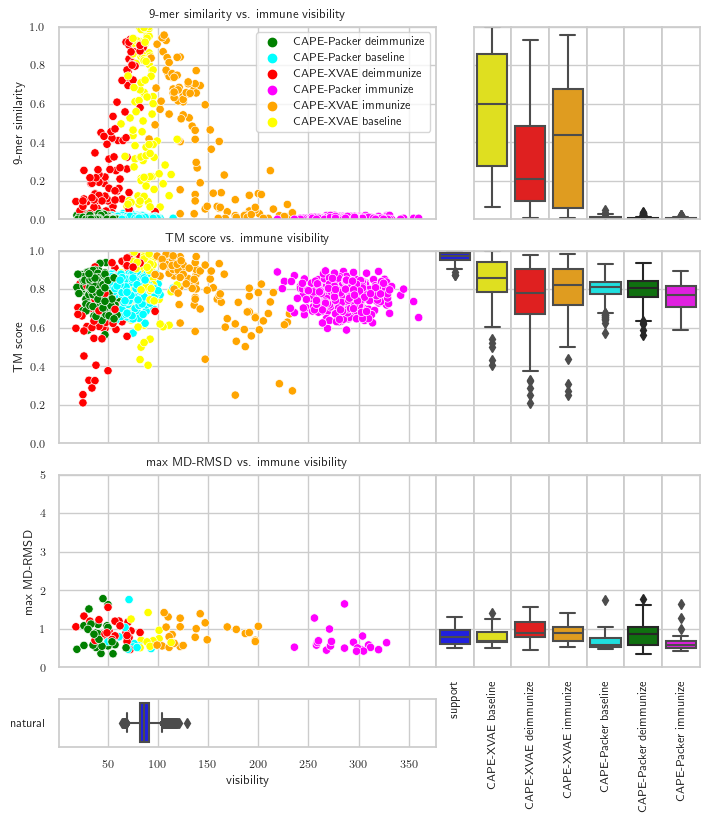

In [58]:
packs_vs_vis = [
    "CAPE-XVAE.baseline.clean", "CAPE-XVAE.deimmunize.final", "CAPE-XVAE.immunize.final",
    "CAPE-Packer.baseline.final", "CAPE-Packer.deimmunize.final", "CAPE-Packer.immunize.final"
]

fig = plt.figure(figsize=(A4_width, A4_height*0.8))
gs = mpl.gridspec.GridSpec(4, 2 + len(packs_vs_vis), 
                           width_ratios=[10, 1] + [1] * len(packs_vs_vis), height_ratios=[4,4,4,1],
                           wspace=0., hspace=0.2)

ax_sharex = plot_vs_visibility(df_eval, "support", packs_vs_vis, "9mer_similarity", "9-mer similarity", gs[0, :])
plot_vs_visibility(df_eval, "support", packs_vs_vis, "max_TMscore", "TM score", gs[1, :], ax_sharex=ax_sharex)
plot_vs_visibility(df_eval, "support", packs_vs_vis, "md_max_rmsd", "max MD-RMSD", gs[2, :], ax_sharex=ax_sharex, ylim=5., xlabel_boxplots=True)

ax1 = plt.subplot(gs[3,0], sharex=ax_sharex)
# ax1.set_title("Data visibility distribution")
sns.boxplot(ax=ax1, data=df_eval.query("source == 'natural'"), x="visibility", y="source", palette=palettes['source'])
ax1.set_ylabel('')

if save_figures:
    fig.savefig(kit.path.join(G.ENV.ARTEFACTS, "figures", G.DOMAIN, f"Figure_C.pdf"), bbox_inches='tight')

### Figure D

#### find highly visible natural, XVAE and Packer sequences

In [60]:
df_natural_high_visibility = df_eval.query(f"source == 'natural' and visibility >= {immunize_visibility_threshold}").sort_values('visibility', ascending=True)
print(f"The {immunize_visibility_percentile:.2%}-centile threshold is {immunize_visibility_threshold} - ({len(df_natural_high_visibility)} natural proteins)")

df_XVAE_high_visibility = df_eval.query(f"pack == '{source_xvae}.immunize.final' and visibility >= {immunize_visibility_threshold} and max_TMscore > 0.95").sort_values('visibility', ascending=True)
print(f"There are {len(df_XVAE_high_visibility)} XVAE immunized seq with a max_TMscore > 0.95 above this")

df_Packer_high_visibility = df_eval.query(f"pack == '{source_packer}.immunize.final' and visibility >= {immunize_visibility_threshold} and max_TMscore > 0.95").sort_values('visibility', ascending=True)
print(f"There are {len(df_Packer_high_visibility)} Packer immunized seq with a max_TMscore > 0.95 above this")

The 99.50%-centile threshold is 107.0 - (127 natural proteins)
There are 6 XVAE immunized seq with a max_TMscore > 0.95 above this
There are 0 Packer immunized seq with a max_TMscore > 0.95 above this


#### add recall and precisoin values

In [ ]:
log_info("Add recall and precision values to all sequences")
cnt = 0
for df_high_visibility in [df_natural_high_visibility, df_XVAE_high_visibility]:
    for idx, row in df_high_visibility.iterrows():
        selected_sequence = db.get_sequence(seq_hash=row.seq_hash)
        selected_seq = selected_sequence['seq']

        df_selected = predictor_MHC_I.get_seq_kmers(selected_seq, MHCs, 9)
        print(f'\r{cnt} Visibility: {row.visibility}  Length: {len(selected_seq)}         ', end='', flush=True)
        
        add_recall(df_eval, df_selected, predictor_MHC_I, MHCs)
        add_precision(df_eval, df_selected)
        df_eval = df_eval.copy()
        cnt += 1
log_info("")

2023-10-19 13:17:55:  Add recall and precision values to all sequences
7 Visibility: 107.0  Length: 211         

In [ ]:
selected = df_XVAE_high_visibility.sort_values('visibility', ascending=True).iloc[0]
print(f'Visibility: {selected.visibility}  TMscore: {selected.max_TMscore}')
print(selected.seq)
selected_sequence = db.get_sequence(seq_hash=selected.seq_hash)
nb_pred = df_eval.query(f"seq_hash == '{selected.seq_hash}'").iloc[0].nb_pred
df_selected_XVAE = predictor_MHC_I.get_seq_kmers(selected_sequence['seq'], MHCs, 9)
add_precision_to_seq_kmers(df_selected_XVAE, natural_kmers_data)
# add_precision_to_seq_kmers_alt(df_selected_XVAE, df_eval)

In [ ]:
selected = df_natural_high_visibility.sort_values('visibility', ascending=True).iloc[0]
print(f'Visibility: {selected.visibility}  TMscore: {selected.max_TMscore}')
print(selected.seq)
selected_sequence = db.get_sequence(seq_hash=selected.seq_hash)
df_selected_natural = predictor_MHC_I.get_seq_kmers(selected_sequence['seq'], MHCs, 9)
add_precision_to_seq_kmers(df_selected_natural, natural_kmers_data, consider_one=True)
# add_precision_to_seq_kmers_alt(df_selected_natural, df_eval)

#### plot figure

In [ ]:
def plot_immunized_seqs(df_eval, d_df_selected):
    fig = plt.figure(figsize=(A4_width, A4_height/2))
    gs = mpl.gridspec.GridSpec(
        1 + len(d_df_selected), 
        len(d_df_selected) + 1, 
        height_ratios=[2] + [1]*len(d_df_selected), 
        width_ratios=[1]*len(d_df_selected) + [1],
        wspace=0.1, hspace=0.3)

    all_axes = []
    for idx, (source, df_selected) in enumerate(d_df_selected.items()):
        ax = plot_seq_epitopes(gs[0, idx], df_selected, legend=(idx < 1), title=f"{source}\n")
        offset = -0.4 if idx == 0 else 0
        all_axes.append((ax, offset))

    ax = plot_seqs_precision_bar(gs[0, -1], d_df_selected, font_scale=0.6, kind='bar')
    all_axes.append((ax, -0.05))

    for idx, (source, df_selected) in enumerate(d_df_selected.items()):
        ax = plot_epitope_recall_by_seq(gs[1 + idx, :], predictor_MHC_I, 
            df_eval.query(f'source == "natural" and seq_hash != "{df_selected.seq_hash}"'), 
            df_selected.seq_hash)
        ax.set_xlim(0.0, 1.0)

        if idx != 0:
            ax.set_title('')
        
        if idx != (len(d_df_selected) - 1):
            ax.set_xlabel('')
            ax.set_xticklabels([])
        ax.set_ylabel(f"{source} recall in \n{ax.get_ylabel()}")
        all_axes.append((ax, -0.13))

    labels = [f'{c})' for c in string.ascii_lowercase]
    for i, (ax, x_offset) in enumerate(all_axes):
        ax.text(x_offset, 1.2, labels[i], transform=ax.transAxes,
                fontsize=16*font_scale, fontweight='bold', va='top', ha='right') #, color='red')

    return fig

In [ ]:
fig = plot_immunized_seqs(df_eval, {'natural': df_selected_natural, 'XVAE': df_selected_XVAE})
fig.savefig(kit.path.join(G.ENV.ARTEFACTS, "figures", G.DOMAIN, f"Figure_E_XVAE_natural.pdf"), bbox_inches='tight')

#### Recall metrics 

In [ ]:
result = []
res = calc_recall_metrics(df_eval, df_selected_XVAE.seq_hash)
result.append(pd.Series(data=[res['mean_recall'], res['no_recall']], index=['mean', 'no'], name='selected XVAE'))
res = calc_recall_metrics(df_eval, df_selected_natural.seq_hash)
result.append(pd.Series(data=[res['mean_recall'], res['no_recall']], index=['mean', 'no'], name='selected natural'))
res = calc_recall_metrics(df_eval, list(df_XVAE_high_visibility.seq_hash))
result.append(pd.Series(data=[res['mean_recall'], res['no_recall']], index=['mean', 'no'], name='all XVAE'))
res = calc_recall_metrics(df_eval, list(df_natural_high_visibility.seq_hash))
result.append(pd.Series(data=[res['mean_recall'], res['no_recall']], index=['mean', 'no'], name='all natural'))

In [ ]:
print(pd.DataFrame(result))

### Figure E - phylogenetic Tree

In [ ]:
min_occupancy = 0.8

msa_phylo_packs = ['support']

sf = SequenceFrame()
sf.from_seqs(list(df_eval.query(f"""pack in ['{"', '".join(msa_phylo_packs)}']""").seq))

msa_phylo = MultipleSequenceAligner(sf, phylogenetic_tree_model_name = 'raxml')
msa_phylo.msa_annotations = {}
for seq_hash in sf.seq_hash:
    recall_natural = df_eval.query(f"seq_hash == '{seq_hash}'").iloc[0][f'recall_{df_selected_natural.seq_hash}']
    recall_XVAE = df_eval.query(f"seq_hash == '{seq_hash}'").iloc[0][f'recall_{df_selected_XVAE.seq_hash}']
    precision_natural = df_eval.query(f"seq_hash == '{seq_hash}'").iloc[0][f'precision_{df_selected_natural.seq_hash}']
    precision_XVAE = df_eval.query(f"seq_hash == '{seq_hash}'").iloc[0][f'precision_{df_selected_XVAE.seq_hash}']
    msa_phylo.msa_annotations[seq_hash] = \
        f'_RECALL_natural_{recall_natural:.4f}_XVAE_{recall_XVAE:.4f}' + \
        f'_PRECISION_natural_{precision_natural:.4f}_XVAE_{precision_XVAE:.4f}'

msa_phylo.align(msa_file_path=join(G.ENV.ARTEFACTS, 'phylo', G.DOMAIN, 'support.phy'))

#msa_phylo.calculate_occupancy()
#msa_phylo.set_occupancy_threshold(min_occupancy)
msa_phylo.construct_phylogenetic_tree()

### Figure F - alternatives

In [ ]:
def plot_immunized_seqs_new(df_eval, d_df_selected):
    fig = plt.figure(figsize=(A4_width, A4_height*3/4))
    gs = mpl.gridspec.GridSpec(
        1 + len(d_df_selected), 
        2, 
        height_ratios=[1] + [1]*len(d_df_selected), 
        width_ratios=[1, 1],
        wspace=0.1, hspace=0.3)

    all_axes = []
    for idx, (source, df_selected) in enumerate(d_df_selected.items()):
        ax = plot_seq_epitopes(gs[idx, 0], df_selected, legend=(idx < 1), title=f"{source}\n")
        offset = -0.4 if idx == 0 else 0
        all_axes.append((ax, offset))

    ax = plot_seqs_precision_bar(gs[-1, :], d_df_selected, font_scale=0.6, kind='bar')
    all_axes.append((ax, -0.05))

    for idx, (source, df_selected) in enumerate(d_df_selected.items()):
        ax = plot_epitope_recall_by_seq(gs[idx, 1], predictor_MHC_I, 
            df_eval.query(f'source == "natural" and seq_hash != "{df_selected.seq_hash}"'), 
            df_selected.seq_hash)
        ax.set_xlim(0.0, 1.0)

        if idx != 0:
            ax.set_title('')
        
        if idx != (len(d_df_selected) - 1):
            ax.set_xlabel('')
            ax.set_xticklabels([])
        ax.set_ylabel(f"{source} recall in \n{ax.get_ylabel()}")
        all_axes.append((ax, -0.13))

    labels = [f'{c})' for c in string.ascii_lowercase]
    for i, (ax, x_offset) in enumerate(all_axes):
        ax.text(x_offset, 1.2, labels[i], transform=ax.transAxes,
                fontsize=16*font_scale, fontweight='bold', va='top', ha='right') #, color='red')

    return fig

In [ ]:
fig = plot_immunized_seqs_new(df_eval, {'natural': df_selected_natural, 'XVAE': df_selected_XVAE})
#fig.savefig(kit.path.join(G.ENV.ARTEFACTS, "figures", G.DOMAIN, f"Figure_E_XVAE_natural.pdf"), bbox_inches='tight')

In [ ]:
def plot_immunized_seq(df_eval, df_selected, xlim=None):
    fig = plt.figure(figsize=(A4_width, A4_height/2))
    gs = mpl.gridspec.GridSpec(2, 2, width_ratios=[10, 10], height_ratios=[2, 1], wspace=0.1, hspace=0.3)

    ax_seq_epitopes = plot_seq_epitopes(gs[0,0], df_selected)
    ax_precision_pie = plot_seq_precision_pie(gs[0,1], df_selected)
    ax_recall = plot_epitope_recall_by_seq(gs[1,:], predictor_MHC_I, 
        df_eval.query(f'source == "natural" and seq_hash != "{df_selected.seq_hash}"'), 
        df_selected.seq_hash)
    if xlim is not None:
        ax_recall.set_xlim(0.0, xlim)

    all_axes = [(ax_seq_epitopes, -0.4), (ax_precision_pie, -0.1), (ax_recall, -0.13)]
    labels = [f'{c})' for c in string.ascii_lowercase]
    for i, (ax, x_offset) in enumerate(all_axes):
        ax.text(x_offset, 1.2, labels[i], transform=ax.transAxes,
                fontsize=16*font_scale, fontweight='bold', va='top', ha='right') #, color='red')
    return fig

In [ ]:
fig = plot_immunized_seq(df_eval, df_selected_XVAE, xlim=1.)
fig.savefig(kit.path.join(G.ENV.ARTEFACTS, "figures", G.DOMAIN, f"Figure_E_XVAE.pdf"), bbox_inches='tight')

In [ ]:
fig = plot_immunized_seq(df_eval, df_selected_natural, xlim=1.)
fig.savefig(kit.path.join(G.ENV.ARTEFACTS, "figures", G.DOMAIN, f"Figure_E_natural.pdf"), bbox_inches='tight')

# save df_for_eval

In [ ]:
df_eval.to_csv(os.path.join(G.ENV.ARTEFACTS, "df_eval.csv"))

# Close DB

In [ ]:
db.conn.close()

# pymol

In [ ]:
import py3Dmol
from CAPE.RL.reward import rewards_seqs

In [ ]:
seq_hash_support = df_eval.query(f"source == 'support'").seq_hash.iloc[0]
print(f"Suppoprt: {seq_hash_support}")
seq_hash_di = df_eval.sort_values(by=['visibility'], ascending=True).iloc[0].seq_hash
print(f"Suppoprt: {seq_hash_di}")

In [ ]:
def view_structure(seq_hash):
    fasta_file_path = db.get_fasta_file_path(seq_hash)
    pdb_file_path = db.get_pdb_file_path(seq_hash)
    png_file_path = join(G.ENV.ARTEFACTS, 'rendered_structures', f"{seq_hash}_{db.predictor_structure_name}.png")
   
    with open(pdb_file_path) as ifile:
        system = "".join([x for x in ifile])
   
    sequence = kit.bioinf.fasta.read_fasta(fasta_file_path, return_df=True).index[0]
    rewards = rewards_seqs(db.predictors_MHC_I[predictor_MHC_I_name], [sequence], MHCs, 'immunize')[0].astype('int')

    view = py3Dmol.view(width=800, height=800)
    view.addModelsAsFrames(system)

    colors = [
        '#22FFFF',
        '#44BBBB',
        '#669999',
        '#887777',
        '#AA5555',
        '#CC3333',
        '#EE1111',
    ]

    i = 0
    for line in system.split("\n"):
        split = line.split()

        if len(split) == 0 or split[0] != "ATOM":
            continue

        resid = int(split[5])
        if rewards[resid-1] != 0:
            color = colors[rewards[resid-1]]
            idx = int(split[1])

            view.setStyle({'model': -1, 'serial': i+1}, {"sphere": {'color': color}})
        else:
            view.setStyle({'model': -1, 'serial': i+1}, {"cartoon": {}})
        i += 1

    view.zoomTo()
    view.show()
    view.render(filename=png_file_path)
    print(png_file_path)

In [ ]:
view_structure(seq_hash_support)

In [ ]:
view_structure(seq_hash_di)